In [3]:
import matplotlib.pyplot as plt
import seaborn
import pandas
import numpy as np

ur = pandas.read_csv('movie_training_data/user_ratedmovies_train.dat','\t')
 
plt.hist( ur['rating'] )
 
# create a test/train split
 
all_inds = np.random.permutation( range(0,len(ur)) )
test_inds = all_inds[0:85000]
train_inds = all_inds[85000:len(ur)]
 
ur_test = ur.iloc[ test_inds ]
ur_train = ur.iloc[ train_inds ]

## Average Rating Per User

* We hope to find the range of ratings users typically give to movies


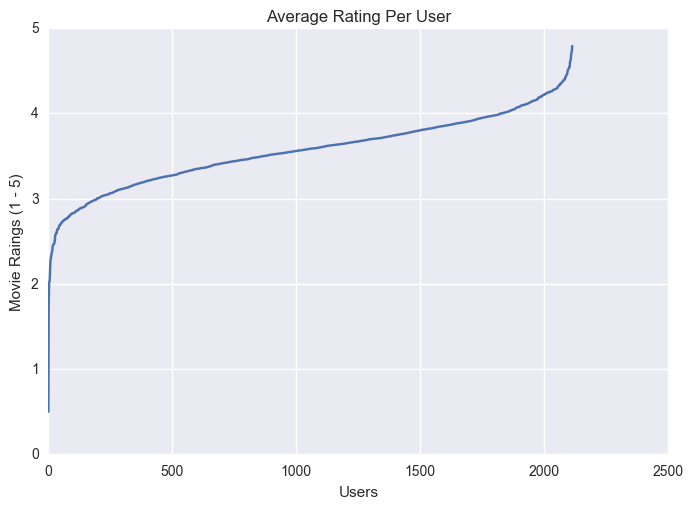

In [62]:
users = ur_train['userID'].unique()
ratings_avg = []
for user in users:
    data = ur_train.loc[ur_train['userID'] == user]
    ratings_avg.append(data['rating'].mean())
    

ratings_avg.sort()
    
plt.plot(np.arange(0, 2113), ratings_avg)
plt.ylim(ymax = 5, ymin = 0)
plt.xlabel("Users")
plt.ylabel("Movie Raings (1 - 5)")
plt.title("Average Rating Per User")
plt.show()

## Average Rating Per Month

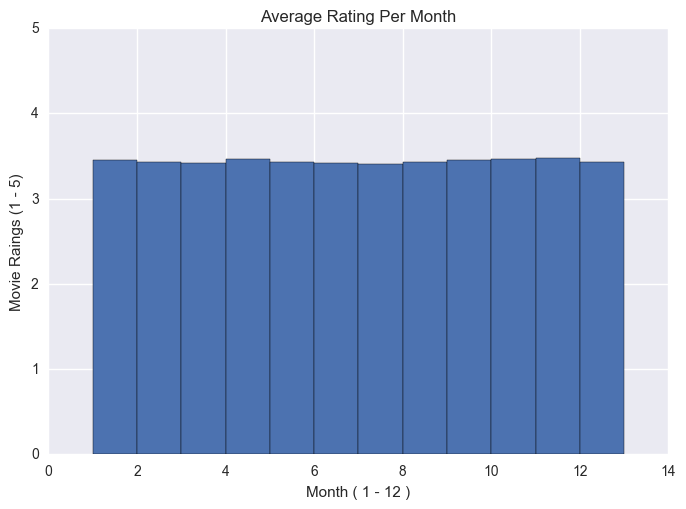

In [53]:
months = np.arange(1, 13)
months_avg = []
for month in months:
    data = ur_train.loc[ur_train['date_month'] == month]
    months_avg.append(data['rating'].mean())


plt.bar(months, months_avg, 1)
plt.ylim(ymax = 5, ymin = 0)
plt.xlabel("Month ( 1 - 12 )")
plt.ylabel("Movie Raings (1 - 5)")
plt.title("Average Rating Per Month")
plt.show()


 ## Number of Movies per Rating

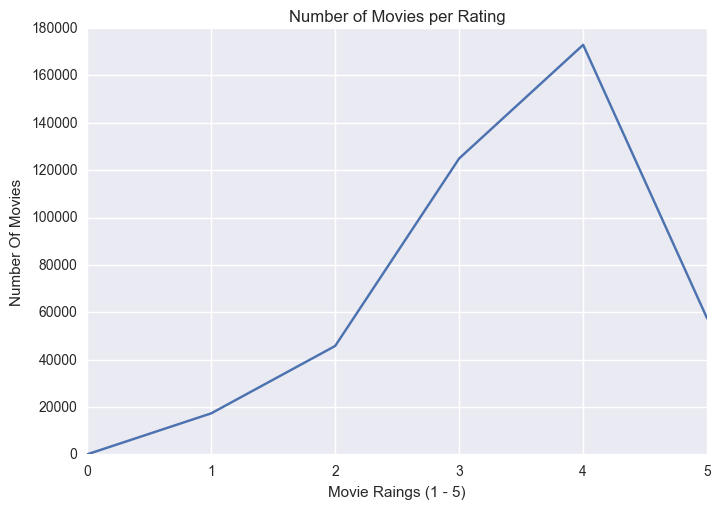

In [68]:
ratings = np.arange(0, 6)
movie_counts = []
for rating in ratings:
    data = ur_train.loc[ur_train['rating'] == rating]
    movie_counts.append(data['movieID'].shape[0])

plt.plot(ratings, movie_counts)
plt.ylabel("Number Of Movies")
plt.xlabel("Movie Raings (1 - 5)")
plt.title("Number of Movies per Rating")
plt.show()



## Number of Ratings per Year

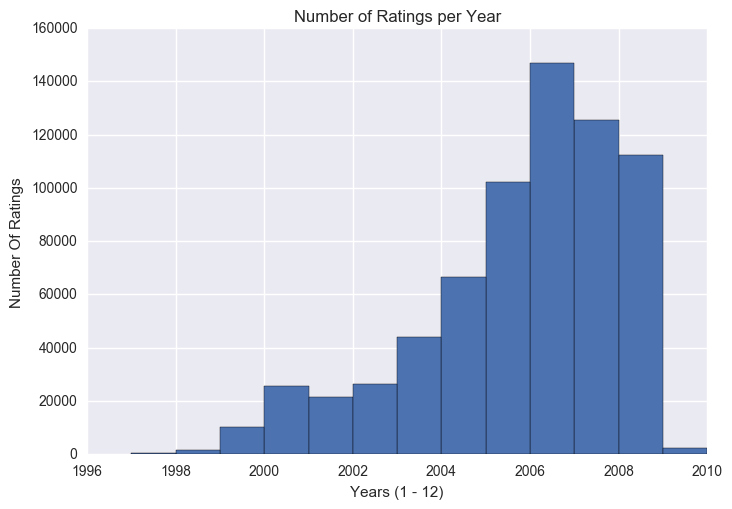

In [78]:
years = ur_train['date_year'].unique()
rating_counts = []
for year in years:
    data = ur_train.loc[ur_train['date_year'] == year]
    rating_counts.append(data['rating'].shape[0])

plt.bar(years, rating_counts, 1)
plt.ylabel("Number Of Ratings")
plt.xlabel("Years (1 - 12)")
plt.title("Number of Ratings per Year")
plt.show()

## Naive Method 1

* "A user has the same opinoin about all movies" Approach
    * Per user, give other movies predictions based on their average ratings for all other movies

In [153]:
users = ur_test['userID'].unique() # 2099
AvgUserRatings = {}
for user in users:
    data = ur_train.loc[ur_train['userID'] == user]
    mean = int(data['rating'].mean())
    if mean % 1 >= 0.5:
        mean = int(mean + 0.5)
        mean += 0.5
    else:
        mean = int(mean + 0.5)
    AvgUserRatings[user] =  mean

In [144]:
'''AUR: Average User Rating'''
AUR_predictions = []
sum_sq_diffs = 0

for user in users:
    #Get Predicted Rating for User
    prediction = AvgUserRatings[user]
    #Get all of the movies for user that need to be assigned a prediction
    data = ur_test.loc[ur_test['userID'] == user] 
    
    movieIDs =  data['movieID']
    for movie in movieIDs:
        data_for_movie = data.loc[data['movieID'] == movie] 
        #real_rating = data_for_movie['rating']
        real_rating = data_for_movie.iloc[0]['rating']
        AUR_predictions.append([user, movie, prediction, real_rating])
        sum_sq_diffs += (prediction - real_rating) ** 2

N = ur_test.shape[0]       
RMSE = (1.0 / N  * sum_sq_diffs) ** 0.5
print "RMSE: ", RMSE
          

RMSE:  1.09256982547


## Naive Method 2
* Assumes that users will give ratings to a movie similar to what other people have given it
    * Per movie, an average of ratings is taken. Then that average becomes a prediction for other users to give to that movie

In [159]:
movies = ur_test['movieID'].unique() #7405
AvgMovieRating = {}
for movie in movies:
    data = ur_train.loc[ur_train['movieID'] == movie]
 
    if data['rating'].shape[0] == 0:
        mean = 0
    else:
        mean = int(data['rating'].mean())
    
    if mean % 1 >= 0.5:
        mean = int(mean + 0.5)
        mean += 0.5
    else:
        mean = int(mean + 0.5)
    AvgMovieRating[movie] =  mean

In [160]:
'''AMR: Average Movie Rating'''
AMR_predictions = []
sum_sq_diffs = 0

for movie in movies:
    prediction = AvgMovieRating[movie]
    data = ur_test.loc[ur_test['movieID'] == movie] 
    
    userIDs =  data['userID']
    for user in userIDs:
        data_for_user = data.loc[data['userID'] == user] 
        #real_rating = data_for_movie['rating']
        real_rating = data_for_user.iloc[0]['rating']
        AMR_predictions.append([user, movie, prediction, real_rating])
        sum_sq_diffs += (prediction - real_rating) ** 2

N = ur_test.shape[0]       
RMSE = (1.0 / N  * sum_sq_diffs) ** 0.5
print "RMSE: ", RMSE

RMSE:  1.07676121117


## Combined Navie Method 3
* Averages the predictions for the last 2 mthods to give a new prediction

In [161]:
combined_predictions = []
sum_sq_diffs = 0

for movie in movies:
    data = ur_test.loc[ur_test['movieID'] == movie] 
    userIDs =  data['userID']
    for user in userIDs:
        prediction = (AvgMovieRating[movie] + AvgUserRatings[user]) / 2.0
        data_for_user = data.loc[data['userID'] == user] 
        real_rating = data_for_user.iloc[0]['rating']
        combined_predictions.append([user, movie, prediction, real_rating])
        sum_sq_diffs += (prediction - real_rating) ** 2

N = ur_test.shape[0]       
RMSE = (1.0 / N  * sum_sq_diffs) ** 0.5
print "RMSE: ", RMSE
        

RMSE:  1.02940159659


## Write UP

#### 1. To better understand the data given, I plotted the data into several different graphs.  

#### NOTE: All graphs are plotted above.

* The first plot shows the average rating per user in general. It gave me an idea of the range of ratings people usually give to movies they have seen. It shows that individual users give average ratings ranging anywhere from 2.5 to 4.7

* The second plot shows the averating rating per month. It showed that the ratings among months were consistant. They were on a bit on the higher end. Approximately 3.5.

* The third plot shows the number of movies per rating. It represented how many movies were usually given particular ratings. This showed that on average, ratings of 3 - 4 where given most often to movies. Ratings 1 - 2.5 and ratings greater that 4 were much less often given

* The last plot shows the number of ratings given per year. It showed that people gave more ratings between the 2006 to 2009. It also showed a dramatic drop of ratings given in 2010, but that is most likely because collection of data was terminated at that time. 

#### 2. Technical Desciption

* The test and training data was previously split for us by Dr. Wingate. He randomly gave us approximately 11% of the data as test data. 

* This approach taken was completely naive and easy to implement. It consisted of parts that were later combined to see if predictions were improved. 

* For Naive Method 1, I assumed that a single user usually gave the same ratings out to all movies. For predictions, I iterated through each user and stored their average given rating. Then as I made predictions to user - movie combinations, I assigned any movie a user had see to their given average ratings computed by the training data.

* For Naive Method 2, I assumed that all users gave each movie similar ratings. For predictions, I iterated through each movie, and stored the average rating given to it. Then as I made predictions to each user - movie combination, I assigned any user's predicted rating according to the movie's average rating computed by the training data. 

* For Naive Method 3, I assumed that predictions were based on the combination of the last two methods. For each user-movie combination, I averaged the last two predictions from each of the previous Naive Methods, and assigned them as new predictions. 



#### 3. An analysis of the approach

* My final RMSE on my last approach was equal to 1.029, which I completely understand is terrible. I do not believe that overfitted the data since the accuracy is very poor. I simply believe that the approach didn't do very well at predicting movie ratings for specific ratings

* Since I basically tried 2 basic naive approaches and then combined them, I believed that it was sufficient time and effort spend on this lab assignment. Therefore, I did not try other approaches. I gave myself 5 hours to complete it. 


In [184]:
from tqdm import tqdm

pred = pandas.read_csv('predictions.dat','\t')

final_predictions = []
for testID in tqdm(xrange(85000)):
    data = pred.loc[pred['testID'] == testID]
    userID = data.iloc[0]['userID']
    movieID = data.iloc[0]['movieID']
    
    user_pred = 3.5
    movie_pred = 3.5
    
    if userID in AvgUserRatings:
        user_pred = AvgUserRatings[userID]
    if movieID in AvgMovieRating:
        movie_pred = AvgMovieRating[movieID]
        
    prediction = (user_pred + movie_pred) / 2.0
    
    final_predictions.append([testID, prediction])


100%|██████████| 85000/85000 [01:12<00:00, 1177.71it/s]


In [185]:
sfile = open( 'predict_full.csv', 'wb' )
sfile.write( '"testID","predicted rating"\n' )
for row in final_predictions:
    sfile.write( '%d,%.2f\n' % ( row[0], row[1]) )
sfile.close()
print "Predictions Written!"

Predictions Written!
